```bash
! uv pip install polars fastexcel
```

datasets can downloaded from 
- https://www.data.gouv.fr/datasets/elections-legislatives-des-30-juin-et-7-juillet-2024-resultats-definitifs-du-2nd-tour/
- https://www.insee.fr/fr/statistiques/6436476?sommaire=6436478


In [90]:
import polars as pl
import polars.selectors as cs

In [110]:
votes = pl.read_excel('https://www.data.gouv.fr/api/1/datasets/r/0257cb91-52f7-4c52-8fad-e3ce57405f71', drop_empty_cols=True)
votes = votes.filter(pl.col('Code département').eq("64"))
votes.head()

Could not determine dtype for column 44, falling back to string
Could not determine dtype for column 54, falling back to string
Could not determine dtype for column 55, falling back to string
Could not determine dtype for column 56, falling back to string
Could not determine dtype for column 57, falling back to string
Could not determine dtype for column 58, falling back to string
Could not determine dtype for column 59, falling back to string
Could not determine dtype for column 60, falling back to string
Could not determine dtype for column 61, falling back to string
Could not determine dtype for column 62, falling back to string
Could not determine dtype for column 63, falling back to string
Could not determine dtype for column 64, falling back to string
Could not determine dtype for column 65, falling back to string
Could not determine dtype for column 66, falling back to string
Could not determine dtype for column 67, falling back to string
Could not determine dtype for column 68,

Code département,Libellé département,Code commune,Libellé commune,Inscrits,Votants,% Votants,Abstentions,% Abstentions,Exprimés,% Exprimés/inscrits,% Exprimés/votants,Blancs,% Blancs/inscrits,% Blancs/votants,Nuls,% Nuls/inscrits,% Nuls/votants,Numéro de panneau 1,Nuance candidat 1,Nom candidat 1,Prénom candidat 1,Sexe candidat 1,Voix 1,% Voix/inscrits 1,% Voix/exprimés 1,Elu 1,Numéro de panneau 2,Nuance candidat 2,Nom candidat 2,Prénom candidat 2,Sexe candidat 2,Voix 2,% Voix/inscrits 2,% Voix/exprimés 2,Elu 2,Numéro de panneau 3,…,Elu 14,Numéro de panneau 15,Nuance candidat 15,Nom candidat 15,Prénom candidat 15,Sexe candidat 15,Voix 15,% Voix/inscrits 15,% Voix/exprimés 15,Elu 15,Numéro de panneau 16,Nuance candidat 16,Nom candidat 16,Prénom candidat 16,Sexe candidat 16,Voix 16,% Voix/inscrits 16,% Voix/exprimés 16,Elu 16,Numéro de panneau 17,Nuance candidat 17,Nom candidat 17,Prénom candidat 17,Sexe candidat 17,Voix 17,% Voix/inscrits 17,% Voix/exprimés 17,Elu 17,Numéro de panneau 18,Nuance candidat 18,Nom candidat 18,Prénom candidat 18,Sexe candidat 18,Voix 18,% Voix/inscrits 18,% Voix/exprimés 18,Elu 18
str,str,str,str,i64,i64,str,i64,str,i64,str,str,i64,str,str,i64,str,str,i64,str,str,str,str,i64,str,str,str,i64,str,str,str,str,i64,str,str,str,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""64""","""Pyrénées-Atlantiques""","""64001""","""Aast""",165,137,"""83,03%""",28,"""16,97%""",124,"""75,15%""","""90,51%""",9,"""5,45%""","""6,57%""",4,"""2,42%""","""2,92%""",5,"""ENS""","""MATTEÏ""","""Jean-Paul""","""MASCULIN""",79,"""47,88%""","""63,71%""","""élu""",6,"""RN""","""BECKER""","""Monique""","""FEMININ""",45,"""27,27%""","""36,29%""",null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""64""","""Pyrénées-Atlantiques""","""64002""","""Abère""",122,98,"""80,33%""",24,"""19,67%""",90,"""73,77%""","""91,84%""",6,"""4,92%""","""6,12%""",2,"""1,64%""","""2,04%""",5,"""ENS""","""MATTEÏ""","""Jean-Paul""","""MASCULIN""",49,"""40,16%""","""54,44%""","""élu""",6,"""RN""","""BECKER""","""Monique""","""FEMININ""",41,"""33,61%""","""45,56%""",null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""64""","""Pyrénées-Atlantiques""","""64003""","""Abidos""",203,150,"""73,89%""",53,"""26,11%""",145,"""71,43%""","""96,67%""",3,"""1,48%""","""2,00%""",2,"""0,99%""","""1,33%""",2,"""RN""","""CRESSON""","""Nicolas""","""MASCULIN""",62,"""30,54%""","""42,76%""",null,5,"""DVG""","""HABIB""","""David""","""MASCULIN""",83,"""40,89%""","""57,24%""","""élu""",null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""64""","""Pyrénées-Atlantiques""","""64004""","""Abitain""",112,91,"""81,25%""",21,"""18,75%""",90,"""80,36%""","""98,90%""",1,"""0,89%""","""1,10%""",0,"""0,00%""","""0,00%""",2,"""UG""","""ECHANIZ""","""Iñaki""","""MASCULIN""",26,"""23,21%""","""28,89%""","""élu""",3,"""DVD""","""LASSALLE""","""Jean""","""MASCULIN""",28,"""25,00%""","""31,11%""",null,4,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""64""","""Pyrénées-Atlantiques""","""64005""","""Abos""",468,359,"""76,71%""",109,"""23,29%""",347,"""74,15%""","""96,66%""",10,"""2,14%""","""2,79%""",2,"""0,43%""","""0,56%""",2,"""RN""","""CRESSON""","""Nicolas""","""MASCULIN""",125,"""26,71%""","""36,02%""",null,5,"""DVG""","""HABIB""","""David""","""MASCULIN""",222,"""47,44%""","""63,98%""","""élu""",null,…,null,null,nu

In [111]:
extract_rn = pl.when(
    pl.col("Nuance candidat 1").eq('"RN"')
).then(
    pl.col("% Voix/exprimés 1")
).when(
    pl.col("Nuance candidat 2").eq("RN")
).then(
    pl.col("% Voix/exprimés 2")
).when(
    pl.col("Nuance candidat 3").eq("RN")
).then(
    pl.col("% Voix/exprimés 3")
).str.replace(r"^(\d+),(\d+)%$", "${1}.${2}").cast(pl.Float64)
votes_rn = votes.select(pl.col("^Code.*$"), percent_rn=extract_rn).filter(pl.col.percent_rn.is_not_null())
votes_rn

Code département,Code commune,percent_rn
str,str,f64
"""64""","""64001""",36.29
"""64""","""64002""",45.56
"""64""","""64004""",40.0
"""64""","""64006""",21.59
"""64""","""64007""",30.34
…,…,…
"""64""","""64550""",34.73
"""64""","""64551""",36.22
"""64""","""64555""",34.83


In [112]:
circo_composition = pl.read_excel("https://www.insee.fr/fr/statistiques/fichier/6436476/circo_composition.xlsx", sheet_name='table').select(
    'COMMUNE_RESID', 'circo'
).filter(pl.col("COMMUNE_RESID").str.starts_with('64'))
circo_composition.head()

COMMUNE_RESID,circo
str,str
"""64001""","""64002"""
"""64002""","""64002"""
"""64003""","""64003"""
"""64004""","""64004"""
"""64005""","""64003"""


In [113]:
stats = pl.read_excel(
    "https://www.insee.fr/fr/statistiques/fichier/6436476/indic-stat-circonscriptions-legislatives-2022.xlsx",
    read_options=dict(header_row=7)
)
stats.head()

circo,Nom de la circonscription,Inscrit_22,pop_légal_19,pop_légal_13,tvar_pop,pop_pole_aav,pop_cour_aav,pop_horsaav,pop_urb,pop_rur_periu,pop_rur_non_periu,age_moyen,dec90,dec75,dec50,dec25,dec10,actemp,actcho,inactret,inactetu,inactm14,inactaut,actemp_hom,actcho_hom,inactret_hom,inactetu_hom,inactm14_hom,inactaut_hom,actemp_fem,actcho_fem,inactret_fem,inactetu_fem,inactm14_fem,inactaut_fem,actdip_PEU,…,ilt_fra,ilt_etr,mobtrav,modtrans_aucun,modtrans_pied,modtrans_velo,modtrans_moto,modtrans_voit,modtrans_commun,tx_pauvrete60_diff,nivvie_median_diff,part_pauvres_diff,part_modestes_diff,part_medians_diff,part_plutot_aises_diff,part_aises_diff,D1_diff,D9_diff,rpt_D9_D1_diff,tx_pauvrete60_diff_trageRF1,tx_pauvrete60_diff_trageRF2,tx_pauvrete60_diff_trageRF3,tx_pauvrete60_diff_trageRF4,tx_pauvrete60_diff_trageRF5,tx_pauvrete60_diff_trageRF6,PACT,PPEN,PPAT,PPSOC,PIMPOT,acc_ecole,acc_college,acc_lycee,acc_medecin,acc_dentiste,acc_pharmacie,part_eloig
str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00000""","""Moyenne France hors Mayotte po…",84094,120483,117922,0.4,50.9,42.5,6.7,67.2,19.1,13.7,41.1,74,60,41,20,8,40.5,6.2,22.5,7.8,16.8,6.2,43.3,6.2,20.9,7.9,17.7,4.1,38.0,6.2,24.0,7.8,15.9,8.1,15.2,…,17.2,1.7,"""nd""",4.1,6.1,2.3,1.8,70.4,15.2,14.5,21930,14.5,25.7,26.5,23.2,10.1,11620,39600,3.4,22.7,16.8,16.5,14.2,10.3,9.6,73.5,28.3,10.1,5.8,-17.7,90.7,61.5,47.2,78.3,71.4,77.0,10.9
"""01001""","""Ain - 1re circonscription""",85723,122750,115683,1.0,28.5,65.3,6.1,28.5,64.8,6.6,41.6,74,61,42,20,8,41.9,4.8,24.3,6.7,17.4,4.9,44.0,4.8,22.6,6.6,18.2,3.8,39.8,4.9,26.0,6.7,16.6,6.0,14.3,…,12.0,0.3,"""27.8""",4.3,5.2,1.7,0.8,84.5,3.5,11.3,22130,11.3,25.9,31.7,24.2,6.9,12720,35890,2.8,16.5,14.2,12.8,10.4,7.8,7.7,70.4,30.6,9.1,5.6,-15.6,96.7,41.1,23.8,65.4,54.2,61.5,14.7
"""01002""","""Ain - 2e circonscription""",99383,137975,129760,1.0,6.1,92.3,1.6,69.9,28.3,1.8,39.2,71,57,40,18,7,46.3,4.1,19.3,7.1,19.1,4.0,48.8,3.8,18.4,6.8,20.1,2.1,43.9,4.4,20.2,7.4,18.2,5.9,13.9,…,50.5,0.2,"""57""",4.2,3.4,1.0,1.1,81.8,8.5,6.8,24890,6.8,20.4,29.0,31.9,12.0,14590,41350,2.8,11.4,7.8,7.3,6.1,5.1,5.5,80.0,23.7,9.7,4.1,-17.5,100.0,47.0,22.1,71.5,62.9,69.3,8.2
"""01003""","""Ain - 3e circonscription""",81500,146110,131843,1.7,8.4,87.0,4.5,78.1,9.5,12.4,37.8,69,54,38,17,7,46.7,5.7,15.6,6.2,20.0,5.8,50.6,5.5,14.3,6.2,20.6,2.7,43.0,5.9,16.8,6.2,19.3,8.8,13.5,…,7.5,48.0,"""57.4""",3.3,5.4,2.7,2.2,77.9,8.4,12.9,28620,12.9,15.9,16.6,20.8,33.9,11500,71720,6.2,16.1,12.6,14.0,13.9,10.6,8.4,87.1,18.9,7.9,2.3,-16.3,98.0,60.1,27.9,76.1,69.6,75.3,24.8
"""01004""","""Ain - 4e circonscription""",94359,128896,126379,0.3,23.4,63.0,13.6,20.5,60.5,19.0,40.9,73,60,42,19,8,44.8,4.2,22.8,6.6,17.9,3.7,47.1,3.9,21.4,6.5,18.7,2.4,42.6,4.5,24.0,6.7,17.0,5.1,14.8,…,36.1,0.2,"""50.5""",4.2,3.5,1.2,1.1,85.0,5.0,8.1,23060,8.1,24.3,32.6,27.0,8.0,13950,37320,2.7,13.0,10.0,8.7,7.3,5.8,6.3,74.1,27.5,9.9,4.6,-16.1,96.6,37.2,26.6,61.0,52.2,57.3,5.6


In [114]:
df = votes_rn.join(
    circo_composition, left_on='Code commune', right_on='COMMUNE_RESID'
).join(
    stats, on="circo"
)
df.head()

Code département,Code commune,percent_rn,circo,Nom de la circonscription,Inscrit_22,pop_légal_19,pop_légal_13,tvar_pop,pop_pole_aav,pop_cour_aav,pop_horsaav,pop_urb,pop_rur_periu,pop_rur_non_periu,age_moyen,dec90,dec75,dec50,dec25,dec10,actemp,actcho,inactret,inactetu,inactm14,inactaut,actemp_hom,actcho_hom,inactret_hom,inactetu_hom,inactm14_hom,inactaut_hom,actemp_fem,actcho_fem,inactret_fem,inactetu_fem,…,ilt_fra,ilt_etr,mobtrav,modtrans_aucun,modtrans_pied,modtrans_velo,modtrans_moto,modtrans_voit,modtrans_commun,tx_pauvrete60_diff,nivvie_median_diff,part_pauvres_diff,part_modestes_diff,part_medians_diff,part_plutot_aises_diff,part_aises_diff,D1_diff,D9_diff,rpt_D9_D1_diff,tx_pauvrete60_diff_trageRF1,tx_pauvrete60_diff_trageRF2,tx_pauvrete60_diff_trageRF3,tx_pauvrete60_diff_trageRF4,tx_pauvrete60_diff_trageRF5,tx_pauvrete60_diff_trageRF6,PACT,PPEN,PPAT,PPSOC,PIMPOT,acc_ecole,acc_college,acc_lycee,acc_medecin,acc_dentiste,acc_pharmacie,part_eloig
str,str,f64,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""64""","""64037""",41.54,"""64001""","""Pyrénées-Atlantiques - 1re …",68649,100813,100556,0.0,68.0,32.0,0.0,91.4,8.6,0.0,42.6,76,62,42,22,10,40.2,6.5,24.1,9.3,13.8,6.0,43.2,6.4,21.2,9.4,15.1,4.5,37.5,6.6,26.7,9.2,…,4.8,0.3,"""26.2""",3.4,5.7,3.6,1.5,79.7,6.1,14.4,22030,14.4,25.6,26.1,24.4,9.6,11640,39070,3.4,28.2,16.9,16.4,13.8,9.0,7.8,68.8,31.9,9.5,6.7,-16.9,99.8,64.1,55.1,91.5,88.0,91.5,1.8
"""64""","""64060""",32.45,"""64001""","""Pyrénées-Atlantiques - 1re …",68649,100813,100556,0.0,68.0,32.0,0.0,91.4,8.6,0.0,42.6,76,62,42,22,10,40.2,6.5,24.1,9.3,13.8,6.0,43.2,6.4,21.2,9.4,15.1,4.5,37.5,6.6,26.7,9.2,…,4.8,0.3,"""26.2""",3.4,5.7,3.6,1.5,79.7,6.1,14.4,22030,14.4,25.6,26.1,24.4,9.6,11640,39070,3.4,28.2,16.9,16.4,13.8,9.0,7.8,68.8,31.9,9.5,6.7,-16.9,99.8,64.1,55.1,91.5,88.0,91.5,1.8
"""64""","""64080""",43.69,"""64001""","""Pyrénées-Atlantiques - 1re …",68649,100813,100556,0.0,68.0,32.0,0.0,91.4,8.6,0.0,42.6,76,62,42,22,10,40.2,6.5,24.1,9.3,13.8,6.0,43.2,6.4,21.2,9.4,15.1,4.5,37.5,6.6,26.7,9.2,…,4.8,0.3,"""26.2""",3.4,5.7,3.6,1.5,79.7,6.1,14.4,22030,14.4,25.6,26.1,24.4,9.6,11640,39070,3.4,28.2,16.9,16.4,13.8,9.0,7.8,68.8,31.9,9.5,6.7,-16.9,99.8,64.1,55.1,91.5,88.0,91.5,1.8
"""64""","""64121""",50.0,"""64001""","""Pyrénées-Atlantiques - 1re …",68649,100813,100556,0.0,68.0,32.0,0.0,91.4,8.6,0.0,42.6,76,62,42,22,10,40.2,6.5,24.1,9.3,13.8,6.0,43.2,6.4,21.2,9.4,15.1,4.5,37.5,6.6,26.7,9.2,…,4.8,0.3,"""26.2""",3.4,5.7,3.6,1.5,79.7,6.1,14.4,22030,14.4,25.6,26.1,24.4,9.6,11640,39070,3.4,28.2,16.9,16.4,13.8,9.0,7.8,68.8,31.9,9.5,6.7,-16.9,99.8,64.1,55.1,91.5,88.0,91.5,1.8
"""64""","""64129""",33.5,"""64001""","""Pyrénées-Atlantiques - 1re …",68649,100813,100556,0.0,68.0,32.0,0.0,91.4,8.6,0.0,42.6,76,62,42,22,10,40.2,6.5,24.1,9.3,13.8,6.0,43.2,6.4,21.2,9.4,15.1,4.5,37.5,6.6,26.7,9.2,…,4.8,0.3,"""26.2""",3.4,5.7,3.6,1.5,79.7,6.1,14.4,22030,14.4,25.6,26.1,24.4,9.6,11640,39070,3.4,28.2,16.9,16.4,13.8,9.0,7.8,68.8,31.9,9.5,6.7,-16.9,99.8,64.1,55.1,91.5,88.0,91.5,1.8


### corelation analysis

In [115]:
def chatterjee_corr(X: pl.Expr, Y: pl.Expr):
  ranks_X, ranks_Y = X.rank('dense'), Y.rank('dense')
  sorted_Y_ranks = ranks_Y.sort_by(ranks_X)
  sum_adjacent_diffs = (sorted_Y_ranks - sorted_Y_ranks.shift(1)).abs().sum()
  n = X.count()
  correlation = pl.when(n <= 1).then(0.0).otherwise(
    1 - (3 * sum_adjacent_diffs) / (n.pow(2) - 1)
  )
  return correlation.clip(0.0, 1.0)

def chatterjee_corr(X: pl.Expr, Y: pl.Expr):
  ranks_X, ranks_Y = X.rank('dense'), Y.rank('dense')
  sorted_Y_ranks = ranks_Y.sort_by(ranks_X)
  sum_adjacent_diffs = (sorted_Y_ranks - sorted_Y_ranks.shift(1)).abs().sum()
  n = X.count()

## corrélation entre 
- Part des actifs en emploi travaillant dans la commune de résidence actuelle (en %)
- pourcentage du RN au second tour

In [116]:
df.select(pl.corr(pl.col.ilt_dep, pl.col.percent_rn))

ilt_dep
f64
-0.30247


In [117]:
df.select(chatterjee_corr(pl.col.ilt_dep, pl.col.percent_rn))

literal
f64
0.0


<Axes: >

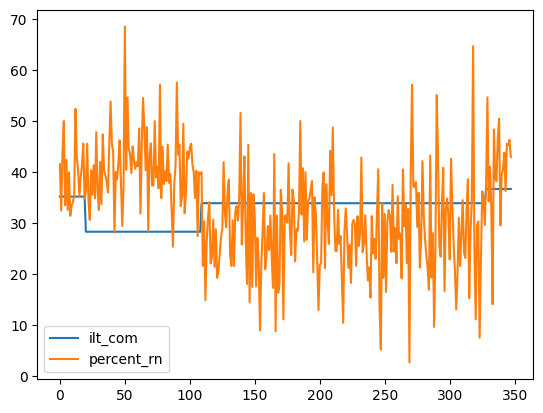

In [119]:
df.select(pl.col.ilt_com, pl.col.percent_rn).to_pandas().plot()

## corrélation entre 
- Part des actifs en emploi travaillant dans la commune de résidence actuelle (en %)
- plus de 2 voitures par ménage

In [123]:
df.select(pl.corr(pl.col.modtrans_voit, pl.col.percent_rn))

modtrans_voit
f64
0.297548
